In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import tensorflow.keras.layers as K_layers
import tensorflow.keras.models as K_models
import tensorflow as tf
from PIL import Image
from skimage import io
import os

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]

In [3]:
def data_generator(batch_size=1):
    while True:
        a = []
        p = []
        n = []
        
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            positive_samples = random.sample(list(x_train[y_train == pos_neg[0]]), 2)
            negative_sample = random.choice(list(x_train[y_train == pos_neg[1]]))      

            a.append(positive_samples[0])
            p.append(positive_samples[1])
            n.append(negative_sample)

#         yield ([np.array(positive_samples[0]),
#                 np.array(positive_samples[1]),
#                 np.array(negative_sample)], np.zeros((batch_size, 1)).astype("float32")) 

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype("float32")) 
        # second argument is expected output, which we don't expect so it can be array of zeros

In [4]:
def calc_cos_tensor(tensor1, tensor2):
    return tf.tensordot(tensor1, tensor2, axes=1) / (tf.norm(tensor1) * tf.norm(tensor2))

In [5]:
def triplet_loss(y_true, y_pred, margin=1.5):
    anchor_out = y_pred[:, 0:100]
    positive_out = y_pred[:, 100:200]
    negative_out = y_pred[:, 200:300]
    
    if tf.norm(anchor_out[0]) == 0:
        tf.print("Zera anchor")
        
    if tf.norm(negative_out[0]) == 0:
        tf.print("Zera negative")
        
    if tf.norm(positive_out[0]) == 0:
        tf.print("Zera positive")
    
    cos1 = calc_cos_tensor(anchor_out[0], positive_out[0])
    cos2 = calc_cos_tensor(anchor_out[0], negative_out[0])
    loss = (1-cos1) - (1-cos2) + margin
        
#     tf.print("\n")
#     tf.print("Loss: ", loss)
                                              
    return loss

In [6]:
# def triplet_loss(y_true, y_pred, margin=0.5):
#     anchor_out = y_pred[:, 0:100]
#     positive_out = y_pred[:, 100:200]
#     negative_out = y_pred[:, 200:300]
    
#     if tf.math.count_nonzero(anchor_out) == 6400:
#         for a in anchor_out:
#             tf.print(a)
    
#     nr_iters = [32, 16, 8, 4, 2, 1]
#     tf_list = []
#     tf_list_tmp = []
    
#     for j in nr_iters:
#         for i in range(j):
#             if j == nr_iters[0]:
#                 cos1_1 = calc_cos_tensor(anchor_out[2*i], positive_out[2*i])
#                 cos1_2 = calc_cos_tensor(anchor_out[2*i], negative_out[2*i])
#                 loss1 = (1-cos1_1) - (1-cos1_2) + margin
                
#                 cos2_1 = calc_cos_tensor(anchor_out[2*i+1], positive_out[2*i+1])
#                 cos2_2 = calc_cos_tensor(anchor_out[2*i+1], negative_out[2*i+1])
#                 loss2 = (1-cos2_1) - (1-cos2_2) + margin
                
#                 tf_list_tmp.append(tf.stack([loss1, loss2], 0))
#             else:
#                 tf_list_tmp.append(tf.concat([tf_list[2*i], tf_list[2*i+1]], 0))

#         tf_list = tf_list_tmp
#         tf_list_tmp = []
        
#     tf.print("\n")
#     tf.print("Loss: ", tf.keras.backend.mean(tf_list[0]))
                                              
#     return tf.keras.backend.mean(tf_list[0])

In [7]:
# def triplet_loss(y_true, y_pred, margin=0.5):
#     anchor_out = y_pred[:, 0:100]
#     positive_out = y_pred[:, 100:200]
#     negative_out = y_pred[:, 200:300]
    
# #     tf.print('\n')
# #     tf.print(tf.math.count_nonzero(anchor_out))
    
#     pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1) # l1 dist between anchor <-> positive
#     neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1) # l1 dist between anchor <-> negative

#     probs = K.softmax([pos_dist, neg_dist], axis=0)
    
#     return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))

In [8]:
input_layer = K_layers.Input((28, 28, 1))
x = K_layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(input_layer)
x = K_layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.MaxPool2D(2)(x)
x = K_layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.MaxPool2D(2)(x)
x = K_layers.Conv2D(256, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.Conv2D(256, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.MaxPool2D(2)(x)
x = K_layers.Conv2D(128, 3, activation="leaky_relu", padding="same")(x)
x = K_layers.Flatten()(x)
x = K_layers.Dense(100, activation="leaky_relu")(x)

model = Model(input_layer, x)
# model.summary()

In [9]:
# input_layer = K_layers.Input((28, 28, 1))
# x = K_layers.Conv2D(32, 3, activation="relu")(input_layer)
# x = K_layers.Conv2D(32, 3, activation="relu")(x)
# x = K_layers.MaxPool2D(2)(x)
# x = K_layers.Conv2D(64, 3, activation="relu")(x)
# x = K_layers.Conv2D(64, 3, activation="relu")(x)
# x = K_layers.MaxPool2D(2)(x)
# x = K_layers.Conv2D(128, 3, activation="relu")(x)
# x = K_layers.Flatten()(x)
# x = K_layers.Dense(100, activation="relu")(x)

# model = Model(input_layer, x)
# model.summary()

In [10]:
triplet_model_a = K_layers.Input((28, 28, 1))
triplet_model_p = K_layers.Input((28, 28, 1))
triplet_model_n = K_layers.Input((28, 28, 1))
triplet_model_out = K_layers.Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
# triplet_model.summary()

In [11]:
triplet_model.compile(loss=triplet_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
# triplet_model.compile(loss=triplet_loss, optimizer="adam")

In [12]:
# triplet_model.fit_generator(data_generator(), steps_per_epoch=1000, epochs=3)
triplet_model.fit(data_generator(), steps_per_epoch=15000, epochs=3)

Epoch 1/3
15000/15000 [==============================] - 1797s 120ms/step - loss: 0.8188
Epoch 2/3
15000/15000 [==============================] - 3183s 212ms/step - loss: 0.6035
Epoch 3/3
15000/15000 [==============================] - 3230s 215ms/step - loss: 0.5240


In [13]:
triplet_model.trainable_variables

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 128) dtype=float32, numpy=
 array([[[[ 0.30415782, -0.37975353,  0.05737551, ..., -0.22537586,
           -0.07790858, -0.05462638]],
 
         [[-0.08283833, -0.09082231, -0.08140026, ..., -0.05242362,
           -0.09532239,  0.08133285]],
 
         [[-0.45043927,  0.0843078 ,  0.04672819, ...,  0.0990141 ,
           -0.04810467,  0.20311098]]],
 
 
        [[[ 0.2208232 ,  0.05981081, -0.06629524, ..., -0.16276526,
            0.04739193, -0.12447008]],
 
         [[ 0.05134624,  0.27938774, -0.1957786 , ...,  0.3552964 ,
            0.28146526, -0.13734375]],
 
         [[-0.19032477,  0.36467397,  0.06281921, ...,  0.5909224 ,
            0.38925838,  0.01356841]]],
 
 
        [[[ 0.08473757, -0.08844905,  0.03870064, ...,  0.01358393,
           -0.12889132, -0.31619835]],
 
         [[ 0.13462493, -0.1609127 ,  0.04398052, ...,  0.21838382,
            0.01967691, -0.06525571]],
 
         [[ 0.27415133, -0.264907  ,  0.0948195

In [14]:
triplet_model.compile(loss=None, optimizer="adam")

In [15]:
triplet_model.save("triplet.h5")

In [16]:
model_embeddings = triplet_model.layers[3].predict(x_test, verbose=1)
print(model_embeddings.shape)

313/313 [==============================] - 63s 201ms/step
(10000, 100)


In [17]:
reduced_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings)
print(reduced_embeddings.shape)

(10000, 2)


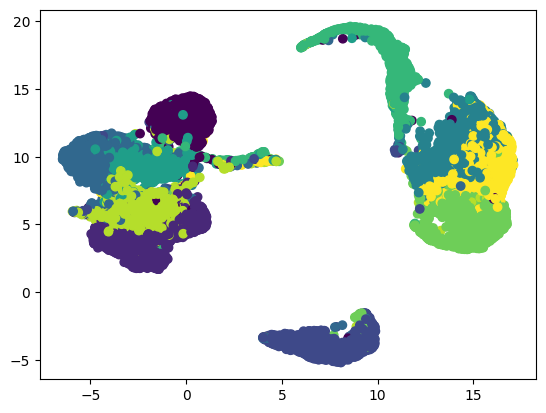

In [18]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_test)